## LightGBMのサンプルコード

In [1]:
# ライブラリーのインポート
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# LightGBM
import lightgbm as lgb

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
print(lgb.__version__)

2.3.0


In [3]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns = boston.feature_names)
# 目的変数の追加
df['MEDV'] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [4]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 0:df.shape[1]-1],
                                                    df.iloc[:, df.shape[1]-1],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

# trainのデータセットの2割をモデル学習時のバリデーションデータとして利用する
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                    y_train,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

# LightGBMを利用するのに必要なフォーマットに変換
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [5]:
# LightGBMのパラメータ設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse', 'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'vervose': 0
}

In [6]:
# LightGBM学習

# 学習の経過を保存する箱
evaluation_results = {}

model = lgb.train(params,
                  lgb_train,
                  num_boost_round=200,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_eval],
                  evals_result=evaluation_results,
                  early_stopping_rounds=50,
                 )

[1]	train's l1: 6.23481	train's rmse: 8.79083	train's l2: 77.2787	valid's l1: 5.32153	valid's rmse: 6.84719	valid's l2: 46.884
Training until validation scores don't improve for 50 rounds
[2]	train's l1: 5.96065	train's rmse: 8.44817	train's l2: 71.3716	valid's l1: 5.12522	valid's rmse: 6.60331	valid's l2: 43.6037
[3]	train's l1: 5.70723	train's rmse: 8.14074	train's l2: 66.2716	valid's l1: 4.92632	valid's rmse: 6.3457	valid's l2: 40.2679
[4]	train's l1: 5.46826	train's rmse: 7.85321	train's l2: 61.6729	valid's l1: 4.74975	valid's rmse: 6.10892	valid's l2: 37.3189
[5]	train's l1: 5.24635	train's rmse: 7.58533	train's l2: 57.5372	valid's l1: 4.59964	valid's rmse: 5.89978	valid's l2: 34.8074
[6]	train's l1: 5.0373	train's rmse: 7.3247	train's l2: 53.6513	valid's l1: 4.44292	valid's rmse: 5.69115	valid's l2: 32.3891
[7]	train's l1: 4.84156	train's rmse: 7.0788	train's l2: 50.1094	valid's l1: 4.30162	valid's rmse: 5.50325	valid's l2: 30.2858
[8]	train's l1: 4.66638	train's rmse: 6.85946	tr

In [7]:
# LightGBM推論
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

In [8]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame({'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

In [9]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE        MSE      RMSE
scores  0.736449  3.445936  27.562373  5.249988


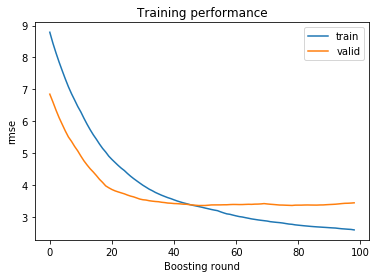

In [10]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['rmse'], label='train')
plt.plot(evaluation_results['valid']['rmse'], label='valid')
plt.ylabel('rmse')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()